# Анализ токсичности комментариев <a id="title"></a>

**Цель исследования**:

1. Проанализировать данные о токсичности комментариев.
2. Разработать модель, которая будет определять токсичность комментария. Метрика F1 модели должна быть не меньше 0.75.

**Ход исследования**:

Основные данные получаем из файла: ```toxic_comments.csv```. Он содержит  набор данных с разметкой о токсичности правок.

Мы проверим данные на наличие пропусков и дубликатов, проведем анализ.
После чего подготовим выборку для обучения моделей. Вычислим для текстов TF-IDF, подберем лучшие параметры для моделей и посчитаем качество на тестовой выборке.
Затем получим эмбеддинги BERT и обучим модели на них. Для новых моделей также посчитаем качество на тестовой выборке.
Наконец, сравним модели и выберем лучшую, учитывая также критерий заказчика (F1 ≥ 0.75).

Таким образом, исследование пройдет в 6 этапов
1. Загрузка данных
2. Предобработка и анализ данных
3. Подготовка выборки, вычисление TF-IDF, подбор параметров и обучение моделей
4. Получение эмбеддингов BERT, подбор параметров и обучение моделей
5. Получение результатов на тестовой выборке, выбор лучшей модели
6. Написание общего вывода

## Подготовка

### Импорт библиотек и объявление констант

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import torch
import transformers

from tqdm import notebook
from tqdm.auto import tqdm

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline

from lightgbm import LGBMClassifier

from wordcloud import WordCloud

In [2]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.2
F1_THRESHOLD = 0.75

### Загрузка данных

In [4]:
data = pd.read_csv('./datasets/toxic_comments.csv', index_col=0)

Посмотрим на первые строки датафрейма.

In [5]:
pd.set_option('display.max_colwidth', None)
data.head(10)

,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0
5,"""\n\nCongratulations from me as well, use the tools well. · talk """,0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0
8,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics? 93.161.107.169",0
9,alignment on this subject and which are contrary to those of DuLithgow,0


Посмотрим на общую информацию о датафрейме.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


В датафрейме 159292 строк и 2 столбца - строковый ```text``` (текст комментария) и целочисленный ```toxic``` (целевой признак токсичности - 0 или 1). Пропусков нет.

### Анализ данных

Проверим на наличие дубликатов.

In [7]:
data['text'].duplicated().sum()

0

Дубликатов не обнаружено.

Проверим баланс классов.

In [8]:
data['toxic'].value_counts()

,count
toxic,
0,143106
1,16186


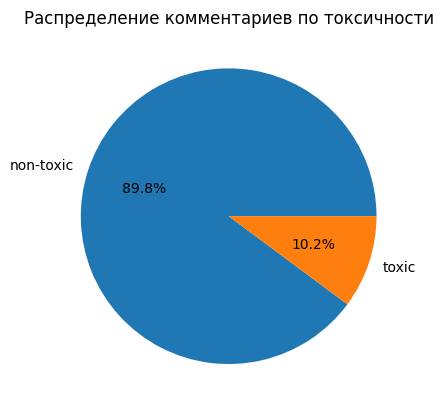

In [9]:
data['toxic'].value_counts().plot(kind='pie', labels=['non-toxic', 'toxic'], autopct='%1.1f%%')
plt.title('Распределение комментариев по токсичности')
plt.ylabel('')
plt.show()

Классы несбалансированы, большая часть комментариев нетоксична.

### Подготовка - итог

Загрузили набор данных с разметкой о токсичности правок. Имеются данные о токсичности 159292 комментариев.

Пропусков и дубликатов не обнаружено.

Классы несбалансированы - почти 90% нетоксичны.

## Обучение

### Лемматизация

Создадим вспомогательные функции для лемматизации текста. Будем использовать WordNetLemmatizer с учетом частей речи. Удалим из строк лишние символы и стоп-слова.

In [10]:
def get_wordnet_pos(word):
    '''Возвращает часть речи слова в виде первой буквы -
    валидного тега части речи для WordNetLemmatizer.
    '''
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def clear_text(text):
    '''Очищает текст от лишних символов.
    Возвращает текст, состоящий только из латинских букв и пробелов.
    '''
    return " ".join(re.sub(r'[^a-zA-Z ]', ' ', text).lower().split())

def delete_stopwords(word_tokens):
    '''Удаляет из списка токенов стоп-слова.
    Возвращает строку без стоп-слов.
    '''
    stop_words = set(stopwords.words('english'))
    return " ".join([w for w in word_tokens if not w in stop_words])

def lemmatize(text):
    '''Лемматизирует текст, используя WordNetLemmatizer.
    Возвращает строку лемм, разделенных пробелами, без стоп-слов.
    '''
    lemmatizer = WordNetLemmatizer()
    return delete_stopwords([lemmatizer.lemmatize(w, get_wordnet_pos(w))
                             for w in nltk.word_tokenize(clear_text(text))])

Проверим лемматизацию на одном предложении.

In [11]:
sentence = data.loc[0, 'text']
print('Предложение:', sentence)
print('Лемматизация:', lemmatize(sentence))

Предложение: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Лемматизация: explanation edits make username hardcore metallica fan revert vandalism closure gas vote new york doll fac please remove template talk page since retire


Лемматизируем тексты. Результат лемматизации запишем в столбец ```lemm_text```.

In [12]:
tqdm.pandas()

In [13]:
data['lemm_text'] = data['text'].progress_apply(lambda x: lemmatize(x))

  0%|          | 0/159292 [00:00<?, ?it/s]

In [14]:
data.head()

,text,toxic,lemm_text
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,explanation edits make username hardcore metallica fan revert vandalism closure gas vote new york doll fac please remove template talk page since retire
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,aww match background colour seemingly stuck thanks talk january utc
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,hey man really try edit war guy constantly remove relevant information talk edits instead talk page seem care format actual info
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,make real suggestion improvement wonder section statistic later subsection type accident think reference may need tidy exact format ie date format etc later one else first preference format style reference want please let know appear backlog article review guess may delay reviewer turn list relevant form eg wikipedia good article nomination transport
4,"You, sir, are my hero. Any chance you remember what page that's on?",0,sir hero chance remember page


После лемматизации могли получиться пустые строки, если комментарий полностью состоял из стоп-слов и символов, отличных от латинских букв. Проверим наличие пустых строк.

In [15]:
data[data['lemm_text'] == ''].shape

(65, 3)

Получили 65 пустых строк. Это совсем немного относительно общего количества (159292), поэтому можем просто удалить эти строки.

In [16]:
data = data[data['lemm_text'] != '']

In [17]:
data[data['lemm_text'] == ''].shape

(0, 3)

In [18]:
data.shape

(159227, 3)

In [19]:
data.head(10)

,text,toxic,lemm_text
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,explanation edits make username hardcore metallica fan revert vandalism closure gas vote new york doll fac please remove template talk page since retire
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,aww match background colour seemingly stuck thanks talk january utc
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,hey man really try edit war guy constantly remove relevant information talk edits instead talk page seem care format actual info
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,make real suggestion improvement wonder section statistic later subsection type accident think reference may need tidy exact format ie date format etc later one else first preference format style reference want please let know appear backlog article review guess may delay reviewer turn list relevant form eg wikipedia good article nomination transport
4,"You, sir, are my hero. Any chance you remember what page that's on?",0,sir hero chance remember page
5,"""\n\nCongratulations from me as well, use the tools well. · talk """,0,congratulation well use tool well talk
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,cocksucker piss around work
7,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0,vandalism matt shirvington article revert please ban
8,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics? 93.161.107.169",0,sorry word nonsense offensive anyway intend write anything article wow would jump vandalism merely request encyclopedic one use school reference selective breeding page almost stub point animal breeding short messy article give info must someone around expertise eugenics
9,alignment on this subject and which are contrary to those of DuLithgow,0,alignment subject contrary dulithgow


Также проверим, что в лемматизированных строках нет дубликатов.

In [20]:
data.duplicated().sum()

0

Дубликатов не обнаружено.

В качестве дополнительного анализа можем построить wordcloud для нетоксичных и токсичных комментариев.

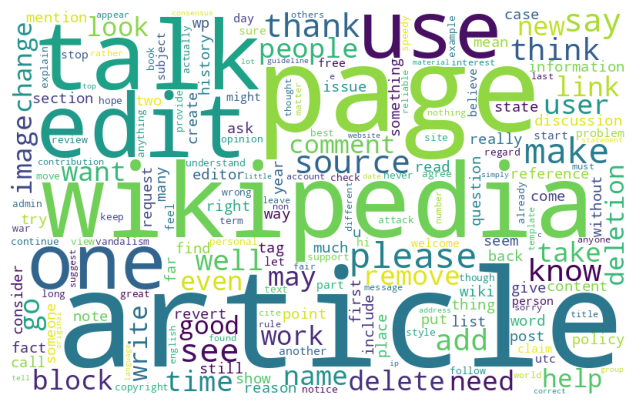

In [21]:
wordcloud = WordCloud(
    collocations=False,
    width=800,
    height=500,
    background_color="white"
).generate(" ".join(data[data['toxic'] == 0]['lemm_text']))
plt.figure( figsize=(8, 5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

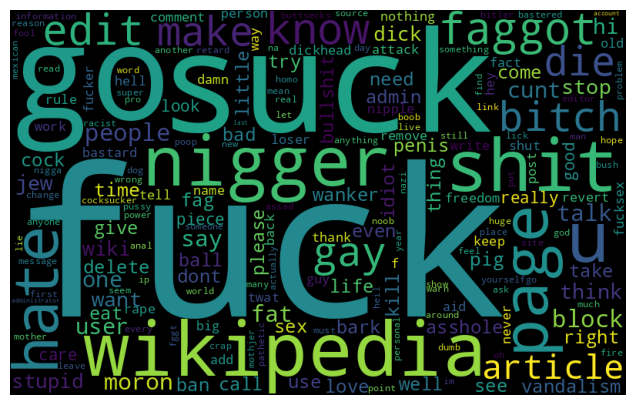

In [22]:
wordcloud = WordCloud(
    collocations=False,
    width=800,
    height=500
).generate(" ".join(data[data['toxic'] == 1]['lemm_text']))
plt.figure( figsize=(8, 5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Наиболее частые слова в токсичных и нетоксичных комментариях значительно отличаются. Модель на TF-IDF должна неплохо справиться.

### Обучение с TF-IDF в качестве признаков

#### Вспомогательные функции

In [23]:
def test_model(model, features, target, threshold):
    '''Получает предсказания модели на заданных признаках,
    подсчитывает f1, сравнивает с заданным порогом.
    Выводит на экран результат сравнения с порогом,
    возвращает f1-меру модели.
    '''
    pred = model.predict(features)
    f1 = f1_score(target, pred)
    if f1 >= threshold:
        print(f'F1-мера {f1:.4f}. Удовлетворяет условию "F1 ≥ {threshold:.2f}"')
    else:
        print(f'F1-мера {f1:.4f}. Не удовлетворяет условию "F1 ≥ {threshold:.2f}"')
    return f1

Вычислим TF-IDF для корпуса текстов и обучим модели классификации на полученных признаках.

#### Подготовка выборки

Разделим выборку на train и test.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    data['lemm_text'],
    data['toxic'],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=data['toxic']
)

Проверим размерности.

In [25]:
X_test.shape[0] + X_train.shape[0], data['toxic'].shape[0]

(159227, 159227)

#### Подсчет TF-IDF

Создадим пайплайн для вычисления TF-IDF и обучения классификаторов.

In [26]:
pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer()),
        ("models", LogisticRegression(random_state=RANDOM_STATE)),
    ]
)

#### LogisticRegression - подбор лучших параметров

Подберем лучшие параметры для LogisticRegression, используя RandomizedSearch.

In [27]:
param_grid_lr = {
    'models': [LogisticRegression(random_state=RANDOM_STATE)],
    'models__C': [0.1, 1, 10],
    'models__solver': ['lbfgs', 'liblinear', 'saga', 'sag'],
    'models__max_iter': [100, 200, 500],
    'models__class_weight': [None, 'balanced']
}

In [30]:
random_search_tfidf = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid_lr,
    cv=5,
    scoring='f1',
    n_jobs=1,
    n_iter=20,
    random_state=RANDOM_STATE
)

In [31]:
random_search_tfidf.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                             ('models',
                                              LogisticRegression(random_state=42))]),
                   n_iter=20, n_jobs=1,
                   param_distributions={'models': [LogisticRegression(random_state=42)],
                                        'models__C': [0.1, 1, 10],
                                        'models__class_weight': [None,
                                                                 'balanced'],
                                        'models__max_iter': [100, 200, 500],
                                        'models__solver': ['lbfgs', 'liblinear',
                                                           'saga', 'sag']},
                   random_state=42, scoring='f1')

Топ-5 моделей:

In [32]:
(pd.DataFrame(random_search_tfidf.cv_results_)
 .sort_values(by='mean_test_score', ascending=False)
 [['rank_test_score', 'param_models', 'params', 'mean_test_score']]
 .head()
)

,rank_test_score,param_models,params,mean_test_score
16,1,LogisticRegression(random_state=42),"{'models__solver': 'lbfgs', 'models__max_iter': 500, 'models__class_weight': None, 'models__C': 10, 'models': LogisticRegression(random_state=42)}",0.772054
9,2,LogisticRegression(random_state=42),"{'models__solver': 'saga', 'models__max_iter': 200, 'models__class_weight': None, 'models__C': 10, 'models': LogisticRegression(random_state=42)}",0.769917
5,2,LogisticRegression(random_state=42),"{'models__solver': 'saga', 'models__max_iter': 100, 'models__class_weight': None, 'models__C': 10, 'models': LogisticRegression(random_state=42)}",0.769917
17,4,LogisticRegression(random_state=42),"{'models__solver': 'liblinear', 'models__max_iter': 100, 'models__class_weight': None, 'models__C': 10, 'models': LogisticRegression(random_state=42)}",0.769865
1,5,LogisticRegression(random_state=42),"{'models__solver': 'saga', 'models__max_iter': 100, 'models__class_weight': 'balanced', 'models__C': 10, 'models': LogisticRegression(random_state=42)}",0.746439


In [33]:
print('Параметры лучшей модели:\n', random_search_tfidf.best_params_)
print ('\nМетрика лучшей модели на кросс-валидации:', random_search_tfidf.best_score_)

Параметры лучшей модели:
 {'models__solver': 'lbfgs', 'models__max_iter': 500, 'models__class_weight': None, 'models__C': 10, 'models': LogisticRegression(random_state=42)}

Метрика лучшей модели на кросс-валидации: 0.7720536454183093


#### LightGBM - подбор лучших параметров

Подберем лучшие параметры для LightGBMClassifier, используя GridSearch.

In [34]:
param_grid_lgb = {
    'models': [LGBMClassifier(verbosity=-1)],
    'models__n_estimators': [100, 200],
    'models__learning_rate': [0.01, 0.05, 0.1]
}

In [39]:
grid_search_tfidf = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid_lgb,
    cv=5,
    scoring='f1',
    n_jobs=1
)

In [40]:
grid_search_tfidf.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('models',
                                        LogisticRegression(random_state=42))]),
             n_jobs=1,
             param_grid={'models': [LGBMClassifier(verbosity=-1)],
                         'models__learning_rate': [0.01, 0.05, 0.1],
                         'models__n_estimators': [100, 200]},
             scoring='f1')

Топ-5 моделей:

In [41]:
pd.set_option('display.max_colwidth', None)
(pd.DataFrame(grid_search_tfidf.cv_results_)
 .sort_values(by='mean_test_score', ascending=False)
 [['rank_test_score', 'param_models', 'params', 'mean_test_score']]
 .head()
)

,rank_test_score,param_models,params,mean_test_score
5,1,LGBMClassifier(verbosity=-1),"{'models': LGBMClassifier(verbosity=-1), 'models__learning_rate': 0.1, 'models__n_estimators': 200}",0.764554
4,2,LGBMClassifier(verbosity=-1),"{'models': LGBMClassifier(verbosity=-1), 'models__learning_rate': 0.1, 'models__n_estimators': 100}",0.745020
3,3,LGBMClassifier(verbosity=-1),"{'models': LGBMClassifier(verbosity=-1), 'models__learning_rate': 0.05, 'models__n_estimators': 200}",0.744108
2,4,LGBMClassifier(verbosity=-1),"{'models': LGBMClassifier(verbosity=-1), 'models__learning_rate': 0.05, 'models__n_estimators': 100}",0.710103
1,5,LGBMClassifier(verbosity=-1),"{'models': LGBMClassifier(verbosity=-1), 'models__learning_rate': 0.01, 'models__n_estimators': 200}",0.639549


In [42]:
print('Параметры лучшей модели:\n', grid_search_tfidf.best_params_)
print ('\nМетрика лучшей модели на кросс-валидации:', grid_search_tfidf.best_score_)

Параметры лучшей модели:
 {'models': LGBMClassifier(verbosity=-1), 'models__learning_rate': 0.1, 'models__n_estimators': 200}

Метрика лучшей модели на кросс-валидации: 0.7645537689210937


#### Тестирование моделей

Посчитаем f1-меру для LogisticRegression на тестовой выборке.

In [43]:
model_lr_tfidf = random_search_tfidf.best_estimator_
f1_lr_tfidf = test_model(model_lr_tfidf, X_test, y_test, F1_THRESHOLD)

F1-мера 0.7752. Удовлетворяет условию "F1 ≥ 0.75"


Посчитаем f1-меру для LGBMClassifier на тестовой выборке.

In [44]:
model_lgb_tfidf = grid_search_tfidf.best_estimator_
f1_lgb_tfidf = test_model(model_lgb_tfidf, X_test, y_test, F1_THRESHOLD)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


F1-мера 0.7732. Удовлетворяет условию "F1 ≥ 0.75"


#### Обучение на TF-IDF - итог

+ Лемматизировали тексты, вычислили TF-IDF.
+ На полученных признаках обучили логистическую регрессию и LGBMClassifier.
+ Лучшие параметры LogisticRegression: ```solver='lbfgs', max_iter=500, class_weight=None, C=10```. F1 на тестовой выборке - 0.7752. Удовлетворяет условию ```F1 ≥ 0.75```.
+ Лучшие параметры LGBMClassifier: ```learning_rate=0.1, n_estimators=200```. F1 на тестовой выборке - 0.7732. Удовлетворяет условию ```F1 ≥ 0.75```.
+ Лучшая модель на TF-IDF - LogisticRegression ```solver='lbfgs', max_iter=500, class_weight=None, C=10```: показала немного лучшие результаты как на кросс-валидации, так и на тестовой выборке.

### Обучение на эмбеддингах BERT

Качество моделей, обученных на TF-IDF, удовлетворяет условию ```F1 ≥ 0.75```, но значения F1-меры близки к нижней границе. Посмотрим, можно ли улучшить качество, используя эмбеддинги BERT.

#### Подготовка подвыборки

По причине нехватки ресурсов для получения эмбеддингов BERT возьмем подвыборку на 5000 документов.
Обучающую и тестовую части возьмем из обучающей и тестовой выборок из предыдущего раздела, чтобы на тестовой подвыборке можно было честно посчитать качество и моделей на TF-IDF.

In [45]:
data_train = y_train.to_frame().join(data, rsuffix='r')
data_train.drop('toxicr', axis=1, inplace=True)
data_train['train'] = 1

In [46]:
pd.set_option('display.max_colwidth', 50)
data_train.head()

,toxic,text,lemm_text,train
100830,0,"t recognize types VIII, IX and XII. I still d...",recognize type viii ix xii still understand pe...,1
70937,0,"""\n\nWelcome\n\nHello, and welcome to Wikipedi...",welcome hello welcome wikipedia thank contribu...,1
91805,0,"""Never said CCM = CCM Magazine. Another exampl...",never say ccm ccm magazine another example foc...,1
65961,0,PKK not being a banned political party \nGerry...,pkk ban political party gerry sorry put discla...,1
34849,0,"if you can't read the telegraph website, it mi...",read telegraph website might register,1


In [47]:
data_test = y_test.to_frame().join(data, rsuffix='r')
data_test.drop('toxicr', axis=1, inplace=True)
data_test['train'] = 0

In [48]:
pd.set_option('display.max_colwidth', 50)
data_test.head()

,toxic,text,lemm_text,train
148564,0,"Done, see Australia (1989 film). Won a couple ...",see australia film couple award least one gold...,0
25545,0,"""\nThe quote I speak of is ALREADY in the arti...",quote speak already article irataba decline he...,0
65169,0,YEAH! I think I can confedently say 95% of all...,yeah think confedently say straight men would ...,0
137672,0,"""\n\nPage protection\nKeilana, can you please ...",page protection keilana please explain semi pr...,0
67577,0,"Welcome, thanks for taking part in editing Wik...",welcome thanks take part edit wikipedia helpfu...,0


In [49]:
sample_train, _ = train_test_split(
    data_train,
    train_size=4000,
    stratify=data_train['toxic'],
    random_state=RANDOM_STATE
)

In [50]:
sample_test, _ = train_test_split(
    data_test,
    train_size=1000,
    stratify=data_test['toxic'],
    random_state=RANDOM_STATE
)

In [51]:
data_bert = pd.concat([sample_train, sample_test])

In [52]:
data_bert

,toxic,text,lemm_text,train
44321,0,Image:SkyNET2.gif\nI have tagged Image:SkyNET2...,image skynet gif tag image skynet gif order im...,1
71903,0,"""::Witkacy, it would be better if you refraine...",witkacy would well refrain say every connectio...,1
14162,0,"(cur) (last) 02:25, 15 September 2008 68.103....",cur last september talk byte undid revision bj...,1
118460,0,"""\n\ndude, if i didnt do what you are telling ...",dude didnt tell guess shouldnt something like ...,1
146731,0,"""\n\nKudzu1 or VQ or both\n\nI know you check ...",kudzu vq know check get life talk,1
...,...,...,...,...
113630,1,hello again\nI am BACK WITH A VENGENCE!!!!!! a...,hello back vengence alright block thats expect...,0
63194,0,"""\nCould not read file. Go back. /home/ftp/pub...",could read file go back home ftp pub sourcefor...,0
7533,0,"Well, that's a functional bug that should be r...",well functional bug report balance ugly functi...,0
92705,0,REDIRECT Talk:Ministry of Food Processing Indu...,redirect talk ministry food processing industry,0


#### Получение эмбеддингов BERT

In [53]:
tokenizer = transformers.BertTokenizer.from_pretrained('unitary/toxic-bert')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/811 [00:00<?, ?B/s]

In [54]:
data_processed = tokenizer.batch_encode_plus(
    data_bert['text'].tolist(),
    padding='max_length',
    truncation=True
)

In [55]:
input_ids = data_processed['input_ids']
attention_mask = data_processed['attention_mask']

In [56]:
model = transformers.BertModel.from_pretrained('unitary/toxic-bert')

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [60]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

batch_size = 100
embeddings = []

model.to(device)

for i in notebook.tqdm(range(len(input_ids) // batch_size)):
        batch = torch.LongTensor(input_ids[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).to(device)

        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)

        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())
        del batch
        del attention_mask_batch
        del batch_embeddings

  0%|          | 0/50 [00:00<?, ?it/s]

In [61]:
features = np.concatenate(embeddings)

In [62]:
features.shape

(5000, 768)

In [63]:
X_train_bert = features[:4000]
X_test_bert = features[4000:]
y_train_bert = data_bert[:4000]['toxic']
y_test_bert = data_bert[4000:]['toxic']

In [64]:
X_train_bert.shape, X_test_bert.shape, y_train_bert.shape, y_test_bert.shape

((4000, 768), (1000, 768), (4000,), (1000,))

#### LogisticRegression - подбор лучших параметров

In [65]:
pipeline = Pipeline(
    [
        ("models", LogisticRegression(random_state=RANDOM_STATE)),
    ]
)

In [67]:
random_search_bert = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid_lr,
    cv=5,
    scoring='f1',
    n_jobs=1,
    n_iter=20,
    random_state=RANDOM_STATE
)

In [68]:
random_search_bert.fit(X_train_bert, y_train_bert)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('models',
                                              LogisticRegression(random_state=42))]),
                   n_iter=20, n_jobs=1,
                   param_distributions={'models': [LogisticRegression(random_state=42)],
                                        'models__C': [0.1, 1, 10],
                                        'models__class_weight': [None,
                                                                 'balanced'],
                                        'models__max_iter': [100, 200, 500],
                                        'models__solver': ['lbfgs', 'liblinear',
                                                           'saga', 'sag']},
                   random_state=42, scoring='f1')

Топ-5 моделей:

In [69]:
pd.set_option('display.max_colwidth', None)
(pd.DataFrame(random_search_bert.cv_results_)
 .sort_values(by='mean_test_score', ascending=False)
 [['rank_test_score', 'params', 'mean_test_score']]
 .head()
)

,rank_test_score,params,mean_test_score
18,1,"{'models__solver': 'liblinear', 'models__max_iter': 500, 'models__class_weight': None, 'models__C': 1, 'models': LogisticRegression(random_state=42)}",0.939093
4,1,"{'models__solver': 'lbfgs', 'models__max_iter': 200, 'models__class_weight': None, 'models__C': 1, 'models': LogisticRegression(random_state=42)}",0.939093
7,1,"{'models__solver': 'saga', 'models__max_iter': 500, 'models__class_weight': None, 'models__C': 1, 'models': LogisticRegression(random_state=42)}",0.939093
11,1,"{'models__solver': 'sag', 'models__max_iter': 200, 'models__class_weight': None, 'models__C': 1, 'models': LogisticRegression(random_state=42)}",0.939093
5,5,"{'models__solver': 'saga', 'models__max_iter': 100, 'models__class_weight': None, 'models__C': 10, 'models': LogisticRegression(random_state=42)}",0.937688


In [70]:
print('Параметры лучшей модели:\n', random_search_bert.best_params_)
print ('\nМетрика лучшей модели на кросс-валидации:', random_search_bert.best_score_)

Параметры лучшей модели:
 {'models__solver': 'lbfgs', 'models__max_iter': 200, 'models__class_weight': None, 'models__C': 1, 'models': LogisticRegression(random_state=42)}

Метрика лучшей модели на кросс-валидации: 0.9390927150187393


#### LightGBM - подбор лучших параметров

In [71]:
grid_search_bert = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid_lgb,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

In [72]:
grid_search_bert.fit(X_train_bert, y_train_bert)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('models',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'models': [LGBMClassifier(verbosity=-1)],
                         'models__learning_rate': [0.01, 0.05, 0.1],
                         'models__n_estimators': [100, 200]},
             scoring='f1')

Топ-5 моделей:

In [73]:
pd.set_option('display.max_colwidth', None)
(pd.DataFrame(grid_search_bert.cv_results_)
 .sort_values(by='mean_test_score', ascending=False)
 [['rank_test_score', 'params', 'mean_test_score']]
 .head()
)

,rank_test_score,params,mean_test_score
3,1,"{'models': LGBMClassifier(verbosity=-1), 'models__learning_rate': 0.05, 'models__n_estimators': 200}",0.936466
2,2,"{'models': LGBMClassifier(verbosity=-1), 'models__learning_rate': 0.05, 'models__n_estimators': 100}",0.936351
4,3,"{'models': LGBMClassifier(verbosity=-1), 'models__learning_rate': 0.1, 'models__n_estimators': 100}",0.934152
5,4,"{'models': LGBMClassifier(verbosity=-1), 'models__learning_rate': 0.1, 'models__n_estimators': 200}",0.932980
1,5,"{'models': LGBMClassifier(verbosity=-1), 'models__learning_rate': 0.01, 'models__n_estimators': 200}",0.923191


In [74]:
print('Параметры лучшей модели:\n', grid_search_bert.best_params_)
print ('\nМетрика лучшей модели на кросс-валидации:', grid_search_bert.best_score_)

Параметры лучшей модели:
 {'models': LGBMClassifier(verbosity=-1), 'models__learning_rate': 0.05, 'models__n_estimators': 200}

Метрика лучшей модели на кросс-валидации: 0.9364660540081692


Таким образом, лучшая модель на кросс-валидации - LogisticRegression(C=1, max_iter=200, solver='lbfgs').

#### Тестирование лучшей модели

Итак, лучшая модель по результатам кросс-валидации - LogisticRegression(C=1, max_iter=500, solver='saga'), обученная на эмбеддингах BERT.
Посчитаем f-меру на тестовой выборке для лучшей модели.

In [75]:
model_lr_bert = random_search_bert.best_estimator_
f1_lr_bert = test_model(model_lr_bert, X_test_bert, y_test_bert, F1_THRESHOLD)

F1-мера 0.9231. Удовлетворяет условию "F1 ≥ 0.75"


На тестовой выборке модель показывает хорошие результаты, удовлетворяющие условию клиента.

#### Обучение на BERT - итог

+ Для BERT выделили подвыборку - 4000 комментариев в train и 1000 - в test
+ Токенизировали тексты, получили эмбеддинги BERT. Использовали модель ```unitary/toxic-bert```.
+ На полученных признаках обучили логистическую регрессию и LGBMClassifier.
+ Лучшие параметры LogisticRegression: ```solver='lbfgs', max_iter=200, class_weight=None, C=1```. F1 на кросс-валидации - 0.939. Удовлетворяет условию ```F1 ≥ 0.75```.
+ Лучшие параметры LGBMClassifier: ```learning_rate=0.05, n_estimators=200```. F1 на кросс-валидации - 0.9365. Удовлетворяет условию ```F1 ≥ 0.75```.
+ По результатам на кросс-валидации выбрали лучшую модель - LogisticRegression. F1 на тестовой выборке - 0.9231, удовлетворяет условию ```F1 ≥ 0.75```.

## Выводы

Проанализировали набор данных с разметкой о токсичности правок, обучили модели, предсказывающие токсичность комментариев.

1. Проанализировали исходные данные. Имеются данные о токсичности 159292 комментариев. Пропусков и дубликатов не обнаружено. Классы несбалансированы - почти 90% нетоксичны.
2. Обучили модели классификации, используя в качестве признаков TF-IDF.
    + Провели лемматизацию, вычислили TF-IDF и обучили модели на большой обучающей выборке (80% от всех данных в train).
    + Подобрали лучшие параметры для моделей и посчитали качество на тестовой выборке:
    + Лучшие параметры LogisticRegression: ```solver='lbfgs', max_iter=500, class_weight=None, C=10```. F1 на тестовой выборке - 0.7752. Удовлетворяет условию ```F1 ≥ 0.75```.
    + Лучшие параметры LGBMClassifier: ```learning_rate=0.1, n_estimators=200```. F1 на тестовой выборке - 0.7732. Удовлетворяет условию ```F1 ≥ 0.75```.
   
2. Выделили подвыборку - 4000 комментариев в train и 1000 - в test. Получили для подвыборки эмбеддинги BERT (использовали предобученную модель ```unitary/toxic-bert```).
    Подобрали лучшие параметры для моделей:
    + Лучшие параметры LogisticRegression: ```solver='lbfgs', max_iter=200, class_weight=None, C=1```. F1 на кросс-валидации - 0.939. Удовлетворяет условию ```F1 ≥ 0.75```.
    + Лучшие параметры LGBMClassifier: ```learning_rate=0.05, n_estimators=200```. F1 на кросс-валидации - 0.9365. Удовлетворяет условию ```F1 ≥ 0.75```.

Таким образом, лучшее качество показала модель LogisticRegression (solver='lbfgs', max_iter=200, class_weight=None, C=1), обученная на эмбеддингах BERT.
F1 лучшей модели на тестовой выборке - 0.9231, удовлетворяет условию ```F1 ≥ 0.75```.

[В начало](#title)